## we will derive and implement the diffusion process. We will use MNIST dataset to build a diffusion model to generate digits.

We will start with variational autoencoders 

$$
\log p_\theta(x)  \geq \sum_{q_\phi(z|x)} \log p_\theta(x|z) - KL(q_\phi(z|x) || p_\theta(z))
$$

The detailed derivation is given in the VAE notebook. 

In diffusion model, we will consider encoder as forward process and decoder as reverse process. we will consider latent variable z as x at different timesteps t=1,2,3...T and observed variable as x_0.

$$
\log p_\theta(x_{0})  \geq \sum_{q_\phi(x_{1:T}|x_{0})} \log p_\theta(x_{0:T}|x_{0}) - KL(q_\phi(x_{1:T}|x_{0}) || p_\theta(x_{1:T}|x_{0}))
$$

The detailed derivation is given [here](https://github.com/AakashKumarNain/diffusion_models/blob/main/notebooks/deep_dive_into_ddpms.ipynb)

I m writing the final equations used in this notebook 

## linear beta schedule 

we have $\beta_{min}$ and $\beta_{max}$ as min and max values of beta. 

$$
\beta_{t} = \beta_{min} + (t/T) * (\beta_{max} - \beta_{min})
$$

Forward process is defined as 

$$
q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_{t}}x_{t-1}, \beta_{t}I)
$$


$$
x_t = \sqrt{1-\beta_{t}}x_{t-1} + \sqrt{\beta_{t}} \epsilon_{t}
$$

where $\epsilon_{t}$ is standard normal noise. 

Using reparametrization trick we can write treat $\alpha_{t}$ as 1-$\beta_{t}$, so after serveral steps of derivations we get $x_{t}$ in terms of $x_{0}$ as 

$$
x_t = \sqrt{\bar{\alpha}_{t}} x_0 + \sqrt{1-\bar{\alpha}_{t}} \epsilon_{t}
$$

where $\bar{\alpha}_{t} = \prod_{i=1}^{t} \alpha_{i}$ and $\alpha_{i} = 1-\beta_{i}$


while training in reverse process we will use $x_{t-1}$ in terms of $x_{t}$ and $\epsilon_{t}$

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} (x_{t} - \frac{1- \alpha_{t}}{\sqrt{1-\bar{\alpha}_{t}}} \epsilon_{t}) + \sigma_{t} z
$$

Note that 

$$
\sigma^2_{t} = \beta_{t} \text{ or } \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t}} \beta_{t}
$$

we will use the second one for $\sigma^2_{t}$ here. 

Also z is standard normal noise and $\epsilon_{t}$ is noise in forward process which is predicted by a deep learning model.

The loss function is defined as 

$$
L = \mathbb{E}_{x_0, \epsilon} [|| \epsilon - \epsilon_\theta(x_t, t) ||^2]
$$

where $\epsilon$ is noise added in forward process and $\epsilon_\theta$ is noise predicted by the model.



In [2]:
# Looad required libraries 

import torch 
import numpy as np
import torchvision
from tqdm import tqdm
from diffusers import UNet2DModel
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [3]:
# Now say we have MNIST data in the shape of (N, 1, 28, 28)
# we will create a VAE model to generate new images similar to the training data. 

# Load MNIST data 

# Load MNIST data and resize it to 64x64
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=128, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=128, shuffle=False)

len(train_loader), len(val_loader)

(469, 79)

In [4]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

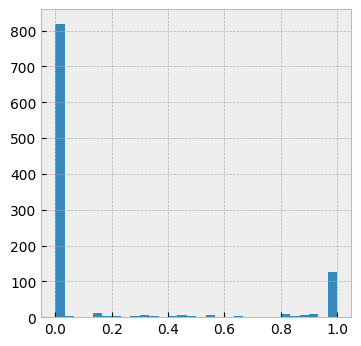

In [5]:
plt.figure(figsize=(4, 4))
plt.hist(imgs[0].view(-1).numpy(), bins=30) #-1 is more because background is black. 
plt.show()


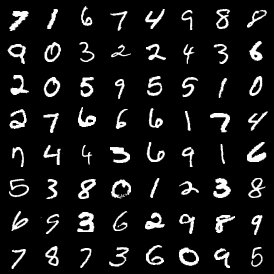

In [6]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs[:64], nrow=8, normalize=False))

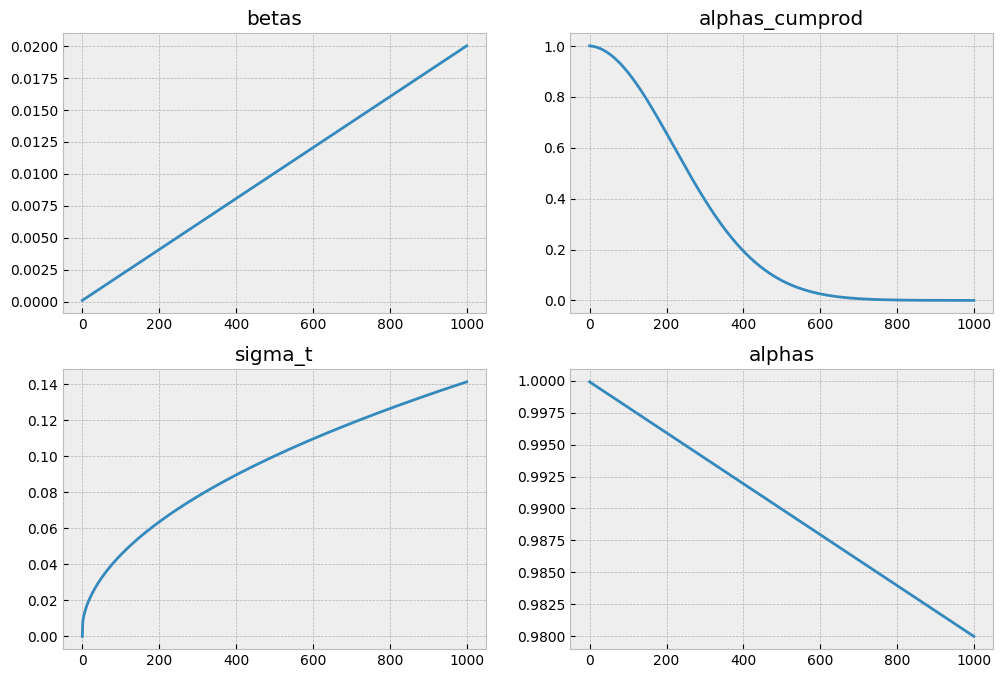

In [7]:
## Lets add some noise to the images using linear beta schedule  
T = 1000
beta_min = 0.0001
beta_max = 0.02
betas = torch.linspace(beta_min, beta_max, T)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), alphas_cumprod[:-1]], dim=0)
sigma_t = torch.sqrt((1 - alphas_cumprod_prev) / (1 - alphas_cumprod)* betas)

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax.flat[0].plot(betas)
ax.flat[1].plot(alphas_cumprod)
ax.flat[2].plot(sigma_t)
ax.flat[3].plot(alphas)
ax.flat[0].set_title('betas')
ax.flat[1].set_title('alphas_cumprod')
ax.flat[2].set_title('sigma_t')
ax.flat[3].set_title('alphas')
plt.show()



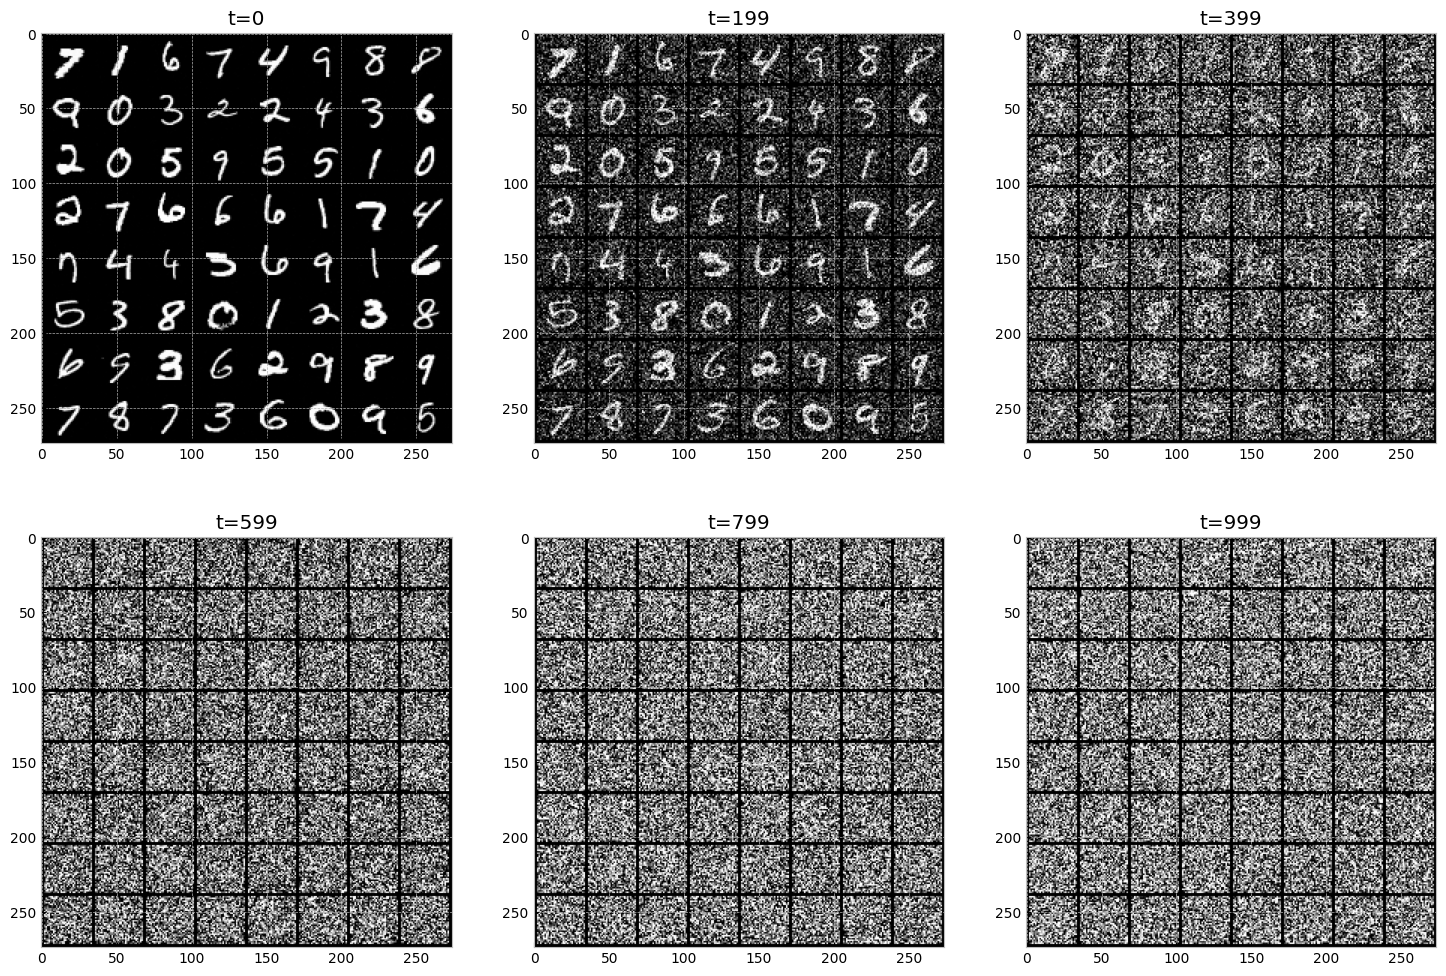

In [8]:
# Lets visualize the forward process (markov process) T = 0, 20, 40, 60, 80, 100
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for n, i in enumerate([0, 199, 399, 599, 799, 999]):
    imgsn = 2*imgs-1 
    xt = torch.sqrt(alphas_cumprod[i]) * imgsn + torch.sqrt(1 - alphas_cumprod[i]) * torch.randn_like(imgsn)
    xt = xt.clamp(-1, 1)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(xt[:64], nrow=8, normalize=True))
    ax.flat[n].imshow(np.asarray(img))
    ax.flat[n].set_title(f't={i}')
plt.show()

In [9]:
# forward step given x0 and t 
def forward_step(x0, t, noise=None):
    alpha_t = alphas_cumprod[t]
    if noise is None:
        noise = torch.randn_like(x0)
    xt = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
    return xt

In [10]:
# Forward process is defined using a UNet architecture. 
# from the paper Our neural network architecture follows the backbone of PixelCNN++ [52], which is a U-Net [48]
# based on a Wide ResNet [72]. We replaced weight normalization [49] with group normalization [66]
# to make the implementation simpler. Our 32 × 32 models use four feature map resolutions (32 × 32
# to 4 × 4), and our 256 × 256 models use six. All models have two convolutional residual blocks
# per resolution level and self-attention blocks at the 16 × 16 resolution between the convolutional
# blocks [6]. Diffusion time t is specified by adding the Transformer sinusoidal position embedding [60]
# into each residual block. Our CIFAR10 model has 35.7 million parameters, and our LSUN and
# CelebA-HQ models have 114 million parameters. We also trained a larger variant of the LSUN
# Bedroom model with approximately 256 million parameters by increasing filter count.
#TODO: implement our own UNet architecture instead of using diffusers

device = "cuda"
model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2, #use 3
    block_out_channels=(128, 256, 512, 512),  
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),  # Add attention
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),  # Add attention
    time_embedding_type='positional',
)

model = model.to(device)

In [11]:
count = 0
for name, param in model.named_parameters():
    count += param.numel()
count # this is a ~16 million parameters model


101117185

In [12]:
# During inference/validation
@torch.no_grad()
def sample_ddpm(model, n_samples, device):
    # Start from pure noise
    if isinstance(n_samples, int):
        x = torch.randn((n_samples, 1, 32, 32)).to(device)
    else:
        x = n_samples 
        n_samples = x.shape[0]
    img_list = []
    
    for t in tqdm(reversed(range(T)), desc='sampling loop time step'):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        
        # Predict noise
        pred_noise = model(x, t_batch)["sample"]
        
        # Update sample with improved scheduler
        alpha = alphas[t]
        alpha_hat = alphas_cumprod[t]
        sigma = sigma_t[t]
        
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
            
        posterior_mean = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * pred_noise) 
        posterior_std = sigma * noise
        x = posterior_mean + posterior_std

        if t in [0, 199, 399, 599, 799, 999]:
            img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(x.clamp(-1, 1).cpu(), nrow=8, normalize=True))
            img_list.append(img)
    
    return x.clamp(-1, 1), img_list

sampling loop time step: 1000it [00:20, 49.45it/s]


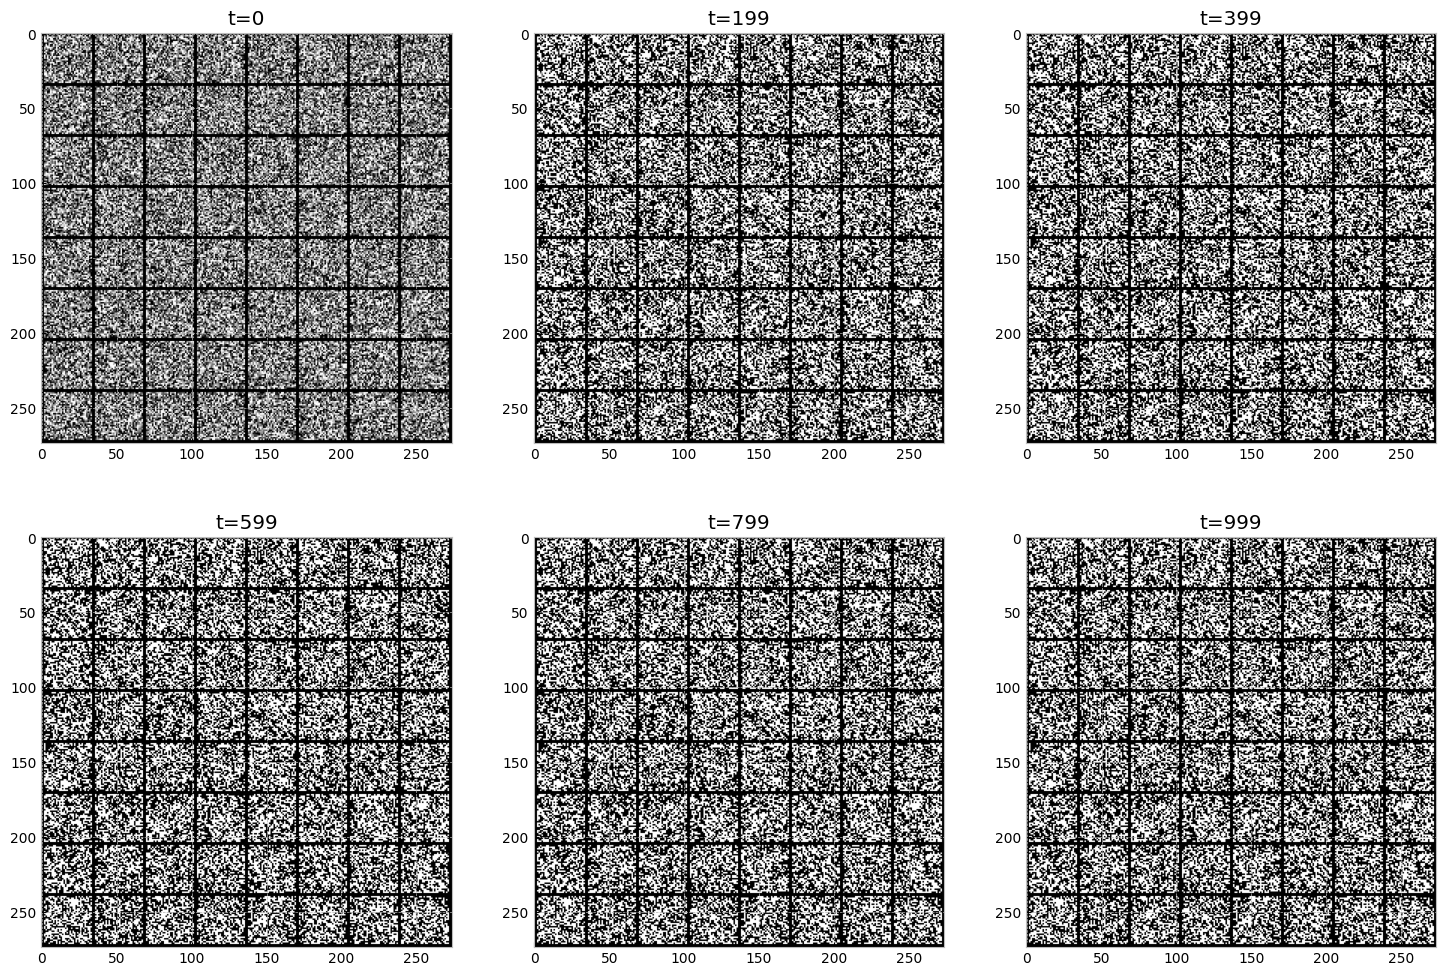

In [13]:
final_img, img_list = sample_ddpm(model, 64, device)

fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for n, (img, t) in enumerate(zip(img_list, [0, 199, 399, 599, 799, 999])):
    ax.flat[n].imshow(np.asarray(img))
    ax.flat[n].set_title(f't={t}')
plt.show()


In [14]:
# we will add EMA weights to the model. 
import copy

def exists(val):
    return val is not None

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
    def update_average(self, old, new):
        if not exists(old):
            return new
        return old * self.beta + (1 - self.beta) * new

ema = EMA(beta=0.9999)
ema_model = copy.deepcopy(model)

In [15]:
epochs = 50
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4) #suggested by cursor. 
total_steps = len(train_loader) * epochs
noise = torch.randn((64, 1, 32, 32), device=device)

iter = 0 
train_loss = []

for epoch in range(epochs):
    model.train()
    epoch_loss = []
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            optimizer.zero_grad()
            
            x0, _ = batch
            t = torch.randint(0, T, (x0.shape[0],), device=x0.device)
            x0 = 2*x0 -1  # scale to -1 to 1
            noise = torch.randn_like(x0)
            xt = forward_step(x0, t.view(-1, 1, 1, 1), noise)
            model_output = model(xt.to(device), t.to(device))["sample"]
            
            loss = torch.nn.functional.mse_loss(model_output, noise.to(device))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Add gradient clipping
            optimizer.step()

            #calculate loss 
            tepoch.set_postfix(loss=loss.item())
            epoch_loss.append(loss.item())
                    
            #update ema model 
            for current_params, ma_params in zip(model.parameters(), ema_model.parameters()):
                    old_weight, up_weight = ma_params.data, current_params.data
                    ma_params.data = ema.update_average(old_weight, up_weight)
    
    train_loss.extend(epoch_loss)
    store = {
         "ema_model": ema_model.state_dict(),
         "model": model.state_dict(),
         "train_loss": np.mean(epoch_loss)
    }
    torch.save(store, f"generated/ema_model_{epoch}_{np.mean(epoch_loss):3f}.pth")
    print(f"Epoch {epoch} completed: train loss {np.mean(epoch_loss)}")
    #TODO: calculate some metric between generated images and original images

    ema_model.eval()
    out, _ = sample_ddpm(ema_model, 128, device)
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.clamp(-1, 1).cpu(), nrow=8, normalize=True))
    img.save(f"generated/generated_images_{epoch}.png")
        

100%|██████████| 469/469 [01:05<00:00,  7.14batch/s, loss=0.0208]


Epoch 0 completed: train loss 0.03626545796643442


sampling loop time step: 1000it [00:36, 27.66it/s]
100%|██████████| 469/469 [01:04<00:00,  7.32batch/s, loss=0.0192]


Epoch 1 completed: train loss 0.020526444660559265


sampling loop time step: 1000it [00:35, 28.35it/s]
100%|██████████| 469/469 [01:05<00:00,  7.17batch/s, loss=0.0175]


Epoch 2 completed: train loss 0.019039337219459922


sampling loop time step: 1000it [00:36, 27.62it/s]
100%|██████████| 469/469 [01:05<00:00,  7.18batch/s, loss=0.0171]


Epoch 3 completed: train loss 0.018347838796230396


sampling loop time step: 1000it [00:35, 28.54it/s]
100%|██████████| 469/469 [01:04<00:00,  7.29batch/s, loss=0.0236]


Epoch 4 completed: train loss 0.01819881803389869


sampling loop time step: 1000it [00:36, 27.62it/s]
100%|██████████| 469/469 [01:05<00:00,  7.17batch/s, loss=0.0156]


Epoch 5 completed: train loss 0.017688042093028645


sampling loop time step: 1000it [00:36, 27.61it/s]
100%|██████████| 469/469 [01:03<00:00,  7.39batch/s, loss=0.0183]


Epoch 6 completed: train loss 0.01760632475254251


sampling loop time step: 1000it [00:36, 27.54it/s]
100%|██████████| 469/469 [01:05<00:00,  7.17batch/s, loss=0.0196]


Epoch 7 completed: train loss 0.017247044167586607


sampling loop time step: 1000it [00:36, 27.64it/s]
100%|██████████| 469/469 [00:51<00:00,  9.14batch/s, loss=0.0202]


Epoch 8 completed: train loss 0.01742707788427946


sampling loop time step: 1000it [00:34, 29.20it/s]
100%|██████████| 469/469 [01:04<00:00,  7.22batch/s, loss=0.0107]


Epoch 9 completed: train loss 0.017194144588623093


sampling loop time step: 1000it [00:35, 27.84it/s]
100%|██████████| 469/469 [01:03<00:00,  7.34batch/s, loss=0.0125]


Epoch 10 completed: train loss 0.017113949875158668


sampling loop time step: 1000it [00:34, 29.04it/s]
100%|██████████| 469/469 [01:04<00:00,  7.22batch/s, loss=0.0133]


Epoch 11 completed: train loss 0.016742378348178828


sampling loop time step: 1000it [00:35, 27.87it/s]
100%|██████████| 469/469 [01:04<00:00,  7.24batch/s, loss=0.0148]


Epoch 12 completed: train loss 0.016808760936246878


sampling loop time step: 1000it [00:35, 28.36it/s]
100%|██████████| 469/469 [01:03<00:00,  7.38batch/s, loss=0.0159]


Epoch 13 completed: train loss 0.01702345087171109


sampling loop time step: 1000it [00:36, 27.77it/s]
100%|██████████| 469/469 [01:04<00:00,  7.23batch/s, loss=0.0147]


Epoch 14 completed: train loss 0.016740448284409702


sampling loop time step: 1000it [00:35, 27.80it/s]
100%|██████████| 469/469 [01:03<00:00,  7.43batch/s, loss=0.0129]


Epoch 15 completed: train loss 0.016547656252678396


sampling loop time step: 1000it [00:36, 27.73it/s]
100%|██████████| 469/469 [01:04<00:00,  7.24batch/s, loss=0.0172]


Epoch 16 completed: train loss 0.016743527850441968


sampling loop time step: 1000it [00:36, 27.76it/s]
100%|██████████| 469/469 [01:03<00:00,  7.40batch/s, loss=0.0158]


Epoch 17 completed: train loss 0.016696513288898637


sampling loop time step: 1000it [00:34, 28.58it/s]
100%|██████████| 469/469 [01:04<00:00,  7.22batch/s, loss=0.0167]


Epoch 18 completed: train loss 0.01656848025609499


sampling loop time step: 1000it [00:36, 27.73it/s]
100%|██████████| 469/469 [01:04<00:00,  7.26batch/s, loss=0.0213]


Epoch 19 completed: train loss 0.0165739847140621


sampling loop time step: 1000it [00:35, 28.51it/s]
100%|██████████| 469/469 [01:03<00:00,  7.35batch/s, loss=0.0208]


Epoch 20 completed: train loss 0.016515442489910482


sampling loop time step: 1000it [00:36, 27.69it/s]
100%|██████████| 469/469 [01:04<00:00,  7.24batch/s, loss=0.0158]


Epoch 21 completed: train loss 0.016489979588607356


sampling loop time step: 1000it [00:35, 27.81it/s]
100%|██████████| 469/469 [01:02<00:00,  7.45batch/s, loss=0.00971]


Epoch 22 completed: train loss 0.016419812826427824


sampling loop time step: 1000it [00:36, 27.73it/s]
100%|██████████| 469/469 [01:04<00:00,  7.24batch/s, loss=0.0171]


Epoch 23 completed: train loss 0.01637188322953324


sampling loop time step: 1000it [00:36, 27.76it/s]
100%|██████████| 469/469 [01:03<00:00,  7.40batch/s, loss=0.0173]


Epoch 24 completed: train loss 0.016315231687510447


sampling loop time step: 1000it [00:35, 28.53it/s]
100%|██████████| 469/469 [01:04<00:00,  7.24batch/s, loss=0.0154]


Epoch 25 completed: train loss 0.016404635989780366


sampling loop time step: 1000it [00:36, 27.73it/s]
100%|██████████| 469/469 [01:04<00:00,  7.23batch/s, loss=0.0197]


Epoch 26 completed: train loss 0.01618467261796313


sampling loop time step: 1000it [00:34, 28.69it/s]
100%|██████████| 469/469 [01:03<00:00,  7.38batch/s, loss=0.0182]


Epoch 27 completed: train loss 0.016247730388411326


sampling loop time step: 1000it [00:36, 27.76it/s]
100%|██████████| 469/469 [00:51<00:00,  9.18batch/s, loss=0.0163]


Epoch 28 completed: train loss 0.016144549517806913


sampling loop time step: 1000it [00:22, 44.45it/s]
100%|██████████| 469/469 [00:43<00:00, 10.66batch/s, loss=0.0145]


Epoch 29 completed: train loss 0.016402164364912743


sampling loop time step: 1000it [00:22, 44.45it/s]
100%|██████████| 469/469 [00:44<00:00, 10.65batch/s, loss=0.0137] 


Epoch 30 completed: train loss 0.016258678786250067


sampling loop time step: 1000it [00:22, 44.47it/s]
100%|██████████| 469/469 [00:43<00:00, 10.71batch/s, loss=0.015] 


Epoch 31 completed: train loss 0.016229686789961256


sampling loop time step: 1000it [00:22, 44.48it/s]
100%|██████████| 469/469 [00:43<00:00, 10.72batch/s, loss=0.0156]


Epoch 32 completed: train loss 0.016094135968431608


sampling loop time step: 1000it [00:22, 44.46it/s]
100%|██████████| 469/469 [00:44<00:00, 10.65batch/s, loss=0.0159]


Epoch 33 completed: train loss 0.016228174882085084


sampling loop time step: 1000it [00:22, 44.49it/s]
100%|██████████| 469/469 [00:44<00:00, 10.66batch/s, loss=0.0196]


Epoch 34 completed: train loss 0.01608591713209841


sampling loop time step: 1000it [00:22, 44.46it/s]
100%|██████████| 469/469 [00:44<00:00, 10.66batch/s, loss=0.0148]


Epoch 35 completed: train loss 0.015906511937011914


sampling loop time step: 1000it [00:22, 44.46it/s]
100%|██████████| 469/469 [00:43<00:00, 10.67batch/s, loss=0.0158]


Epoch 36 completed: train loss 0.016055653876523728


sampling loop time step: 1000it [00:22, 44.47it/s]
100%|██████████| 469/469 [00:44<00:00, 10.66batch/s, loss=0.0182]


Epoch 37 completed: train loss 0.01606113082770981


sampling loop time step: 1000it [00:22, 44.49it/s]
100%|██████████| 469/469 [00:43<00:00, 10.68batch/s, loss=0.017] 


Epoch 38 completed: train loss 0.015995666299309177


sampling loop time step: 1000it [00:22, 44.49it/s]
100%|██████████| 469/469 [00:43<00:00, 10.70batch/s, loss=0.0132]


Epoch 39 completed: train loss 0.01600749499555717


sampling loop time step: 1000it [00:22, 44.48it/s]
100%|██████████| 469/469 [00:43<00:00, 10.71batch/s, loss=0.0189]


Epoch 40 completed: train loss 0.015921150320279066


sampling loop time step: 1000it [00:22, 44.48it/s]
100%|██████████| 469/469 [00:43<00:00, 10.67batch/s, loss=0.0153]


Epoch 41 completed: train loss 0.015970601068773883


sampling loop time step: 1000it [00:22, 44.46it/s]
100%|██████████| 469/469 [00:43<00:00, 10.70batch/s, loss=0.0153]


Epoch 42 completed: train loss 0.01588636031275047


sampling loop time step: 1000it [00:22, 44.48it/s]
100%|██████████| 469/469 [00:43<00:00, 10.68batch/s, loss=0.0169]


Epoch 43 completed: train loss 0.015845943000048462


sampling loop time step: 1000it [00:22, 44.46it/s]
100%|██████████| 469/469 [00:44<00:00, 10.64batch/s, loss=0.0122] 


Epoch 44 completed: train loss 0.015759747689848006


sampling loop time step: 1000it [00:22, 44.44it/s]
100%|██████████| 469/469 [00:44<00:00, 10.64batch/s, loss=0.0178]


Epoch 45 completed: train loss 0.01591779352195545


sampling loop time step: 1000it [00:22, 44.46it/s]
100%|██████████| 469/469 [00:44<00:00, 10.64batch/s, loss=0.0162]


Epoch 46 completed: train loss 0.015983518830605788


sampling loop time step: 1000it [00:22, 44.48it/s]
100%|██████████| 469/469 [00:44<00:00, 10.65batch/s, loss=0.0173]


Epoch 47 completed: train loss 0.01576365099977583


sampling loop time step: 1000it [00:22, 44.45it/s]
100%|██████████| 469/469 [00:44<00:00, 10.64batch/s, loss=0.0142]


Epoch 48 completed: train loss 0.015868820269891955


sampling loop time step: 1000it [00:22, 44.45it/s]
100%|██████████| 469/469 [00:44<00:00, 10.65batch/s, loss=0.0172] 


Epoch 49 completed: train loss 0.015715097520015896


sampling loop time step: 1000it [00:22, 44.46it/s]


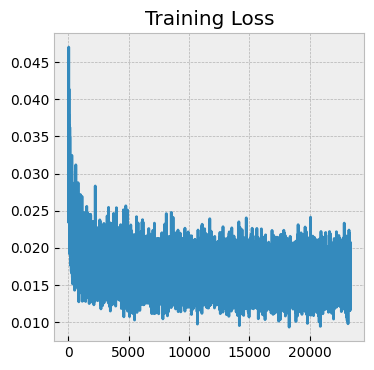

In [16]:
plt.figure(figsize=(4, 4))
plt.plot(train_loss[100:])
plt.title("Training Loss")
plt.show()

In [17]:
# Load the model 
device = "cuda"
model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2, #use 3
    block_out_channels=(128, 256, 512, 512),  
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),  # Add attention
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),  # Add attention
    time_embedding_type='positional',
)

model = model.to(device)
weights_path = "generated/ema_model_49_0.015751.pth"
model.load_state_dict(torch.load(weights_path)["ema_model"])

model.eval()
print("Model loaded")

FileNotFoundError: [Errno 2] No such file or directory: 'generated/ema_model_49_0.015751.pth'

sampling loop time step: 1000it [00:31, 31.34it/s]


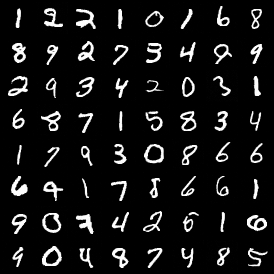

In [13]:
out, _ = sample_ddpm(model, 64, device)
img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.clamp(-1, 1).cpu(), nrow=8, normalize=True))
img

## A note on DDIM 

when we sample from random noise we have 

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_{t}}} (x_{t} - \frac{1- \alpha_{t}}{\sqrt{1-\bar{\alpha}_{t}}} \epsilon_{t}) + \sigma_{t} z
$$

here z = $\mathcal{N}(0, 1)$ which leads to stochasticity in the sampling process.  

This means that even when u sample from the same random vector z, you will basically get different images as z is added at each step. We will see this below 

sampling loop time step: 1000it [00:31, 31.74it/s]


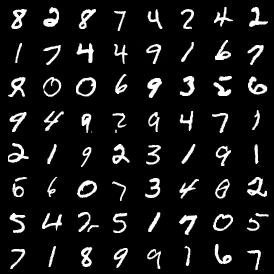

In [14]:
sample = torch.randn((1, 1, 32, 32), device=device)
sample = torch.cat([sample]*64, dim=0)
out, _ = sample_ddpm(model, sample, device)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.clamp(-1, 1).cpu(), nrow=8, normalize=True))


so in DDIM we will use deterministic sampling process. 



$$
x_{t-1} \leftarrow \sqrt{\alpha_{t-1}} \left(\frac{x_t-\sqrt{1-\alpha_t}\hat{\epsilon}}{\sqrt{\alpha_t}}\right) + \sqrt{1-\alpha_{t-1}}\hat{\epsilon}
$$

as u can see the random noise (z) is removed from the equation. 

> TODO: add intution and resource links on how this is derived. 

In [20]:
@torch.no_grad()
def sample_ddim(model, n_samples, step_size, device):
    if isinstance(n_samples, int):
        x = torch.randn((n_samples, 1, 32, 32)).to(device)
    else:
        x = n_samples 
        n_samples = x.shape[0]
    img_list = []
    timesteps = list(range(T-1, -1, -step_size)) + [0]  # Ensure we include 0

    for i, t in enumerate(tqdm(timesteps, desc=f'sampling loop time step in {step_size}')):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        
        # Predict noise
        pred_noise = model(x, t_batch)["sample"]
        
        # Update sample with improved scheduler
        alpha_hat = alphas_cumprod[t]

        if i < len(timesteps) - 1:
            alpha_hat_next = alphas_cumprod[timesteps[i+1]]
            x0_pred = (x - torch.sqrt(1 - alpha_hat) * pred_noise) / torch.sqrt(alpha_hat)
            x = torch.sqrt(alpha_hat_next) * x0_pred + \
                torch.sqrt(1 - alpha_hat_next) * pred_noise
        else:
            x = (x - torch.sqrt(1 - alpha_hat) * pred_noise) / torch.sqrt(alpha_hat)
                   
        #posterior_mean = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * pred_noise) 
        #x = posterior_mean

        if t in [0, 199, 399, 599, 799, 999]:
            img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(x.clamp(-1, 1).cpu(), nrow=8, normalize=True))
            img_list.append(img)
    
    return x.clamp(-1, 1), img_list
    


sampling loop time step in 1: 100%|██████████| 1001/1001 [00:31<00:00, 31.75it/s]


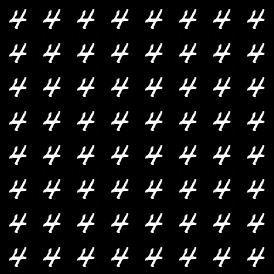

In [21]:
# for step size = 1 
sample = torch.randn((1, 1, 32, 32), device=device)
sample = torch.cat([sample]*64, dim=0)
out, _ = sample_ddim(model, sample, 1, device)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.clamp(-1, 1).cpu(), nrow=8, normalize=True))


sampling loop time step in 2: 100%|██████████| 501/501 [00:15<00:00, 31.73it/s]


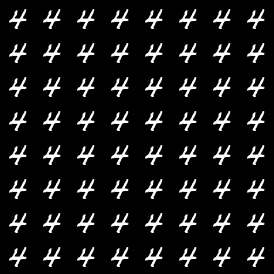

In [22]:
# we use the same sample but use step size = 2 
out, _ = sample_ddim(model, sample, 2, device)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.clamp(-1, 1).cpu(), nrow=8, normalize=True))


sampling loop time step in 50: 100%|██████████| 21/21 [00:00<00:00, 30.50it/s]


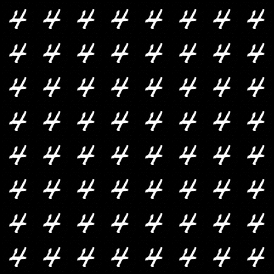

In [23]:
# lets use step size of 50
out, _ = sample_ddim(model, sample, 50, device)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.clamp(-1, 1).cpu(), nrow=8, normalize=True))

sampling loop time step in 100: 100%|██████████| 11/11 [00:00<00:00, 29.93it/s]


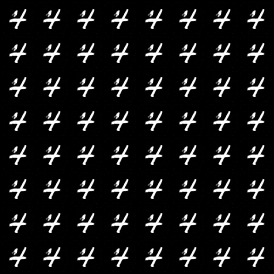

In [24]:
# lets use step size of 100
out, _ = sample_ddim(model, sample, 100, device)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.clamp(-1, 1).cpu(), nrow=8, normalize=True))

> There seems to be some artifacts in the images when step size is 100

So may be 50 is good sweet spot. 

## Sperical interpolation between two images in noise space 

I kind of failed to regenerate the same image which I noised using DDIM. Not sure if this is expected or not, Need to read DDIM paper again.

The interpolation in the noise space is done using spherical interpolation and it works well. we can do other types of interpolation too but that should be separate notebook of its own. 

sampling loop time step in 50: 100%|██████████| 21/21 [00:00<00:00, 103.15it/s]


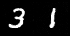

In [44]:
# lets use step size of 100
samples = torch.randn((2, 1, 32, 32), device=device)
out, _ = sample_ddim(model, samples, 50, device)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.clamp(-1, 1).cpu(), nrow=2, normalize=True))

In [45]:
# I copied this code from claude 3.5 sonnet.  
def slerp(t, v0, v1):
    """Spherical linear interpolation."""
    # Normalize the vectors
    v0_norm = v0 / v0.norm(dim=-1, keepdim=True)
    v1_norm = v1 / v1.norm(dim=-1, keepdim=True)
    
    # Compute the cosine of the angle between the vectors
    omega = (v0_norm * v1_norm).sum(dim=-1, keepdim=True)
    omega = omega.clamp(-1, 1)
    
    # If vectors are very close, use linear interpolation
    if (omega > 0.9995).all():
        return (1.0 - t) * v0 + t * v1
    
    # Compute the angle between the vectors
    theta = torch.acos(omega)
    
    # Compute the interpolation
    sin_theta = torch.sin(theta)
    s0 = torch.sin((1.0 - t) * theta) / sin_theta
    s1 = torch.sin(t * theta) / sin_theta
    
    return s0 * v0 + s1 * v1


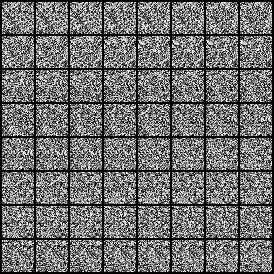

In [46]:
schedule = torch.linspace(0, 1, 64).to("cuda")
interpolated_noise = []

# Interpolate
for schedule_step in schedule:    
    # Spherical interpolation (usually better):
    noise_step = slerp(schedule_step, 
                      samples[0][None, ...], 
                      samples[1][None, ...])
    
    interpolated_noise.append(noise_step)
batch = torch.vstack(interpolated_noise)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(batch.to("cpu"), nrow=8, normalize=False))

sampling loop time step in 50: 100%|██████████| 21/21 [00:00<00:00, 30.72it/s]


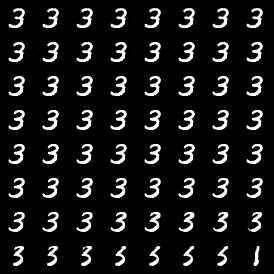

In [47]:
out, _ = sample_ddim(model, batch.to(device), 50, device)
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out.clamp(-1, 1).cpu(), nrow=8, normalize=True))
